In [107]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

Obs: things to change/review
- call daily costs as cost or costs inside classes? for now Im' mixing
- in the Learner class: saving collected_rewards as np.array it's a waste of resource

- step1:
    - I can do better step1 by making Custom_UCB using an UCB1_Learner object instead of extending the class   
      same with TS,  
      i.e. wrapping it instead of extending it  
        Note that this is the approach we are following for step2 and step3


User Class

In [108]:
class UserClass:
    """
    F1 and F2: in {0,1}
        are the binary features
    v: positive number
        is the value per click
    click_function: it is a function
        represents the number of clicks given a bid
    cost_function: it is a function
        represents the cost given a bid
    conversion_rate: a function with image in [0,1] (com: usually descendent)
        it represent how a user is likely to buy the product given a price
        Obs:
        |   in the text says to consider just 5 prices, maybe we can consider this as an array instead of a function
        |__

    """

    def __init__(self, F1, F2, click_function, cost_function, conversion_rate_function):
        self.F1 = F1
        self.F2 = F2
        self.click_function = click_function
        self.cost_function = cost_function
        self.conversion_rate_function = conversion_rate_function



Basic Learner

In [109]:
class Learner:
    """
    Atributes:
    (....)
    rewards_per_arm: a list of list of dimension: number_of_arms x self.t

    (....)
    """

    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0 #current round
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)



# Step 1

-we are just considering one class of users
<br>
-n and c are known
\
-alpha is unknown

### Environment

In [97]:
class PricingEnvironment:

    def __init__(self, prices, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        self.n_arms = len(prices)
        self.prices = prices
        self.user_class = user_class


        self.convertion_probabilities = [user_class.conversion_rate_function(p) for p in prices]


    def round(self, n_daily_clicks, margin, cum_daily_costs, pulled_arm):
        #OBS:
        # The conversion probability is the probability of buying the item given a price, thus is a Bernoulli probabilty

        alpha = self.convertion_probabilities[pulled_arm]
        #here sampled reward
        reward = np.random.binomial(n_daily_clicks, alpha) * margin - cum_daily_costs
        # if reward in expextation: reward = n_daily_clicks * alpha * margin - cum_daily_costs

        return reward

### Learners

Obs: here the arms are for the prices

In [98]:
class UCB1_Learner(Learner):

    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)


    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        #update mean
        # self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.t

        #update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples)

        


class Custom_UCB_Learner(UCB1_Learner):

    def __init__(self, n_arms, n):#n = number of clicks
        super().__init__(n_arms)
        self.n = n


    def update(self, pulled_arm, reward, cost, margin):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        #update mean
        # self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.t
        
        #update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = self.n * np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples) * margin - cost

        

In [99]:
# from Learner import *

class Binomial_TS_Learner(Learner):
    """
    prior: P(p) as Beta(alpha, beta)
    likelihood: p(k|p;n) =  Binomial(n,p)

    By Bayes, we have that:
        posterior: p(p|k;n) = Beta(alpha+k, beta+n-k)
        

    Note:
        - This algorithm learns p assuming n is known (n is the maximum value k can assume)
        - In this simple scenario thr reward we observe is k
    """

    def __init__(self, n_arms, n):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.n = n


    def pull_arm(self):
        idx = np.argmax(np.random.beta( self.beta_parameters[:,0], self.beta_parameters[:,1] ))
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - reward



class Custom_TS_Learner(Binomial_TS_Learner):
    def __init__(self, n_arms, n):
        super().__init__(n_arms, n)


    # def from_reward_to_k(reward, cost, margin):
    #     k = (reward + cost)/margin
    #     return k

    def update(self, pulled_arm, reward, cost, margin):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        k = (reward + cost) / margin#self.from_reward_to_k(cost,margin)
        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + k
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - k



## Example

In [100]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

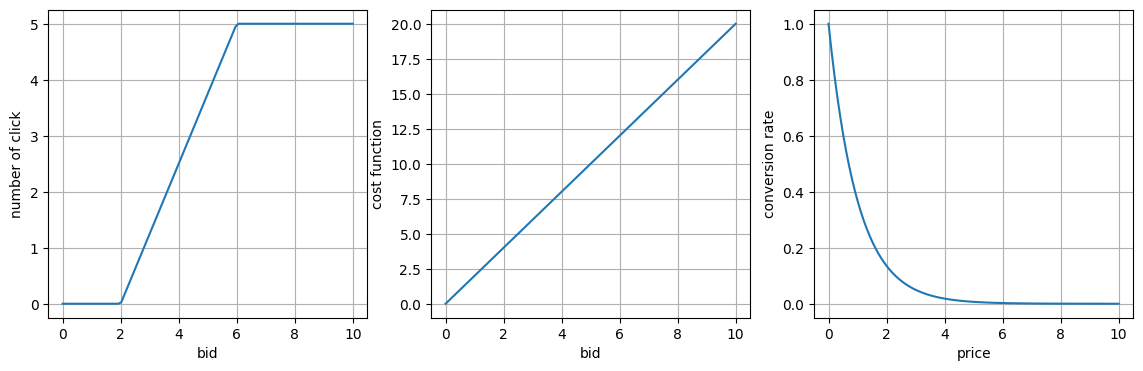

In [101]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

In [102]:
#Fixed parameters
n_arms = 5
T = 365

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = C1.click_function(BID)
cum_daily_costs = C1.cost_function(BID)

margin = 90


#setting the arms
prices = np.array([1,3,5,7,9])
opt_arm = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm]) * margin - cum_daily_costs


n_experiments = 1000

### UCB

In [103]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = PricingEnvironment(prices, C1)
    ucb_learner = Custom_UCB_Learner(n_arms,n_daily_clicks)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(n_daily_clicks, margin, cum_daily_costs, pulled_arm)
        ucb_learner.update(pulled_arm, reward,cum_daily_costs, margin)

        rewards_single_experiment.append(reward)

    ucb_rewards_per_experiment.append(rewards_single_experiment)

### Thompson Sampling

In [104]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = PricingEnvironment(prices, C1)
    ts_learner = Custom_TS_Learner(n_arms,n_daily_clicks)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(n_daily_clicks, margin, cum_daily_costs, pulled_arm)
        ts_learner.update(pulled_arm, reward,cum_daily_costs, margin)

        rewards_single_experiment.append(reward)

    ts_rewards_per_experiment.append(rewards_single_experiment)

### Plots both methods

In [105]:
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

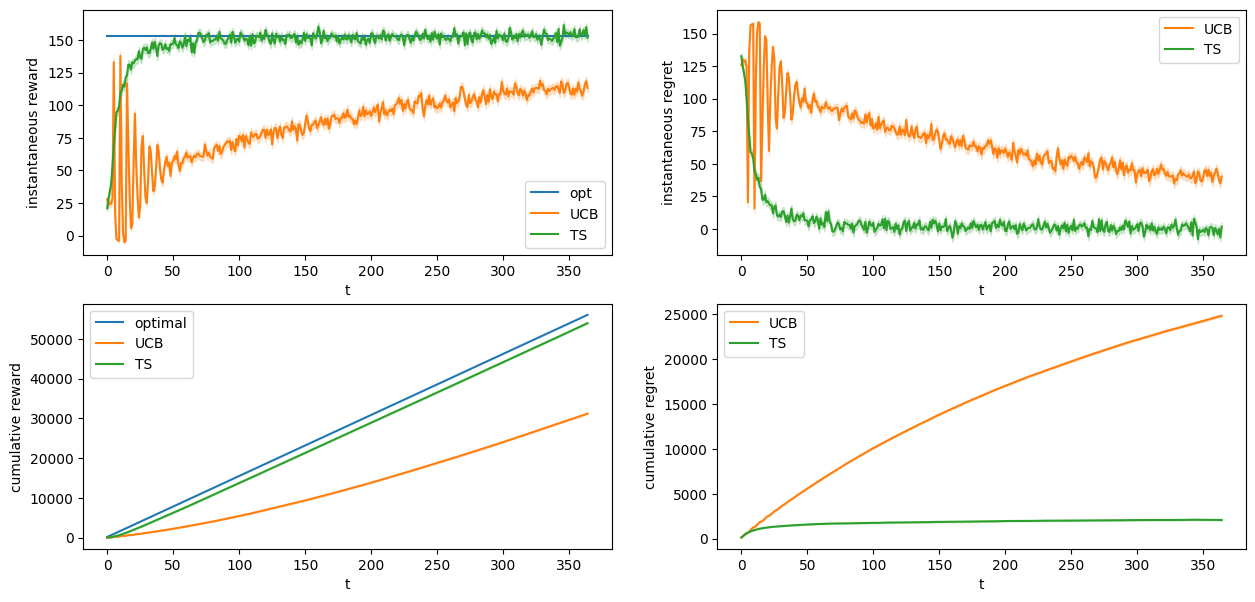

In [106]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

# Step 2

hp:
- just one class of users
- alpha is known
- n and c are unknown

In [110]:
"""
OBS:
I'm assuming that we can see both the n_clicks and the daily cost of the advertising,
(other than the reward, that can be computed by having the n_clciks and the daily cost

obs:
but the reward is not necessary in the update of the learner, it is necessary only choose the arm to be pulled
so I'll use 2 GP-Bandit learners one for the reward and another one for the costs
"""

"\nOBS:\nI'm assuming that we can see both the n_clicks and the daily cost of the advertising,\n(other than the reward, that can be computed by having the n_clciks and the daily cost\n\nobs:\nbut the reward is not necessary in the update of the learner, it is necessary only choose the arm to be pulled\nso I'll use 2 GP-Bandit learners one for the reward and another one for the costs\n"

### Environment

In [111]:
class BiddingEnvironment:
    def __init__(self, bids, user_class, sigma_clicks, sigma_costs):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        # self.n_arms = len(bids)
        self.bids = bids
        self.user_class = user_class

        self.mean_clicks = [user_class.click_function(b) for b in bids]
        self.mean_costs = [user_class.cost_function(b) for b in bids]

        self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
        self.sigmas_costs = np.ones(len(bids)) * sigma_costs


    def round(self, margin, conversion_rate, pulled_arm):
        #OBS:
        n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
        cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

        alpha = conversion_rate # or "np.random.binomial(n_daily_clicks, conversion_rate)" ? imo this complicates the learning
        reward = n_daily_clicks * alpha * margin - cum_daily_costs

        return n_daily_clicks, cum_daily_costs, reward

### Learners

GPUCB

In [112]:
class GPUCB_Learner(Learner):
    def __init__(self, arms, kernel=None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)

        self.arms = arms

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))#Obs: the hyperparamters will be optimized (changed) during learning

        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 4,
                                           normalize_y=True)


    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append(self.arms[arm_idx])


    def pull_arm(self):
        upper_confidence = self.means + self.sigmas
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        x = np.array(self.pulled_arms_x).reshape((-1,1))
        y = np.array(self.collected_rewards)

        if len(y) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(x,y)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-5)



class Custom_GPUCB_Learner(Learner):
    def __init__(self, arms):
        super().__init__(len(arms))

        self.clicks_gpucb_learner = GPUCB_Learner(arms)
        self.costs_gpucb_learner = GPUCB_Learner(arms)


    def pull_arm(self, conversion_rate, margin):
        #upper bounds of clicks and lower bounds of costs
        ub_clicks = self.clicks_gpucb_learner.means + self.clicks_gpucb_learner.sigmas
        lb_costs = self.costs_gpucb_learner.means -  self.costs_gpucb_learner.sigmas

        alpha = conversion_rate
        upper_confidence = ub_clicks * alpha * margin - lb_costs
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually reward is computable: reward = n_daily_clicks * alpha * margin - cum_daily_costs, where alpha = conversion_rate
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.clicks_gpucb_learner.update(pulled_arm, n_daily_clicks)
        self.costs_gpucb_learner.update(pulled_arm, cum_daily_costs)

GPTS

In [113]:
class GPTS_Learner(Learner):
    def __init__(self, arms, kernel = None):
        super().__init__(len(arms))
        self.arms = arms

        n_arms = len(arms)
        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []#here we will save the values of the pulled arms (not the indexes)

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))#Obs: the hyperparamters will be optimized (changed) during learning

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = 0.5**2,
                                           n_restarts_optimizer = 9,#the higher the slower the run, try 4
                                           normalize_y=True)


    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append(self.arms[arm_idx])

    def pull_arm(self):
        sampled_values = np.random.normal(self.means, self.sigmas)
        idx = np.argmax(sampled_values)
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        x = np.array(self.pulled_arms_x).reshape((-1,1))
        y = np.array(self.collected_rewards)

        if len(y) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(x,y)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)



class Custom_GPTS_Learner(Learner):
    def __init__(self, arms):
        super().__init__(len(arms))

        self.clicks_gpts_learner = GPTS_Learner(arms)
        self.costs_gpts_learner = GPTS_Learner(arms)

    def pull_arm(self, conversion_rate, margin):
        sampled_clicks = np.random.normal(self.clicks_gpts_learner.means, self.clicks_gpts_learner.sigmas)
        sampled_costs = np.random.normal(self.costs_gpts_learner.means, self.costs_gpts_learner.sigmas)

        alpha = conversion_rate
        idx = np.argmax(sampled_clicks * alpha * margin - sampled_costs)
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: reward is computable if we have the margin as input: reward = n_daily_clicks * alpha * margin - cum_daily_costs, where alpha = conversion_rate
        self.t += 1
        self.update_observations(pulled_arm, reward)


        self.clicks_gpts_learner.update(pulled_arm, n_daily_clicks)
        self.costs_gpts_learner.update(pulled_arm, cum_daily_costs)

## Example

In [114]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max


    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

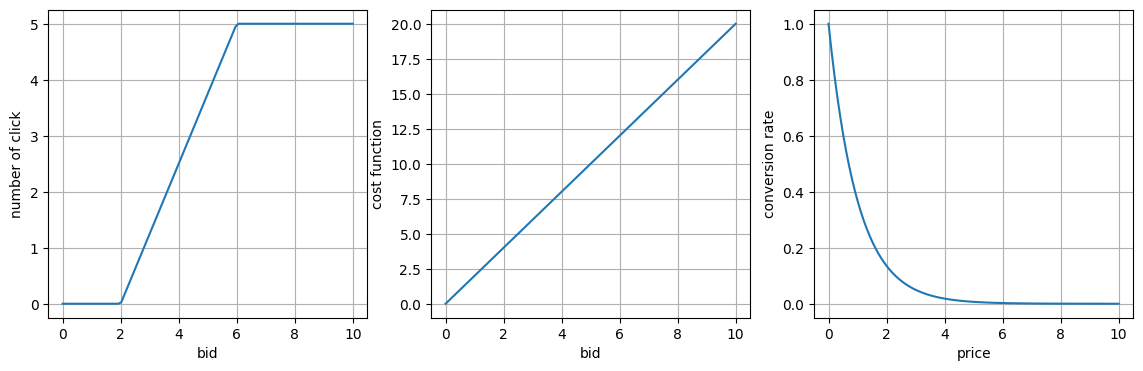

In [115]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

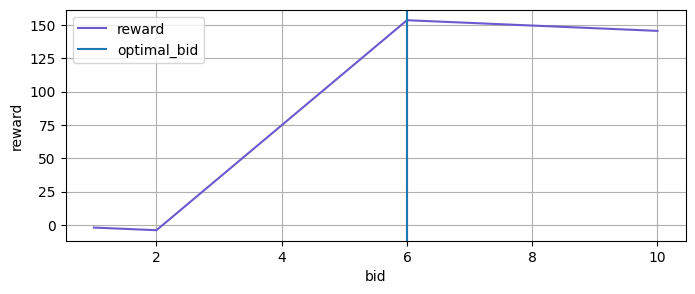

In [116]:
#Fixed parameters
T = 100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the releated conversion rate
PRICE = 1
conversion_rate = C1.conversion_rate_function(PRICE)

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)

rewards_on_arms = C1.click_function(bids) * conversion_rate * margin - C1.cost_function(bids)
opt_arm = np.argmax(rewards_on_arms) #optimal value of convertion rate between the arms
opt = rewards_on_arms[opt_arm]




n_experiments = 20




plt.figure(figsize=(8,3))
plt.plot(bids, rewards_on_arms, "slateblue")
plt.axvline(bids[opt_arm])
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(["reward","optimal_bid"])
plt.grid(True)

### UCB

In [117]:
## UCB learner

gpucb_rewards_per_experiment = []

gpucb_n_daily_clicks_hat = np.zeros(len(bids))
gpucb_n_daily_clicks_std = np.zeros(len(bids))

gpucb_cum_daily_costs_hat = np.zeros(len(bids))
gpucb_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
gpucb_pulled_arms_counter = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = BiddingEnvironment(bids, C1, sigma_clicks, sigma_costs)
    gpucb_learner = Custom_GPUCB_Learner(bids)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = gpucb_learner.pull_arm(conversion_rate, margin)
        n_daily_clicks, cum_daily_costs, reward = env.round(margin, conversion_rate, pulled_arm)
        gpucb_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

        rewards_single_experiment.append(reward)
    gpucb_rewards_per_experiment.append(rewards_single_experiment)

    mean_prediction, std_prediction = gpucb_learner.clicks_gpucb_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpucb_n_daily_clicks_hat += mean_prediction / n_experiments
    gpucb_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = gpucb_learner.costs_gpucb_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpucb_cum_daily_costs_hat += mean_prediction / n_experiments
    gpucb_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    gpucb_pulled_arms_counter += np.array([gpucb_learner.clicks_gpucb_learner.pulled_arms_x.count(bid) for bid in bids]) / n_experiments

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pack

20.0%
25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pack

45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%
55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pa

60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65.0%
70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


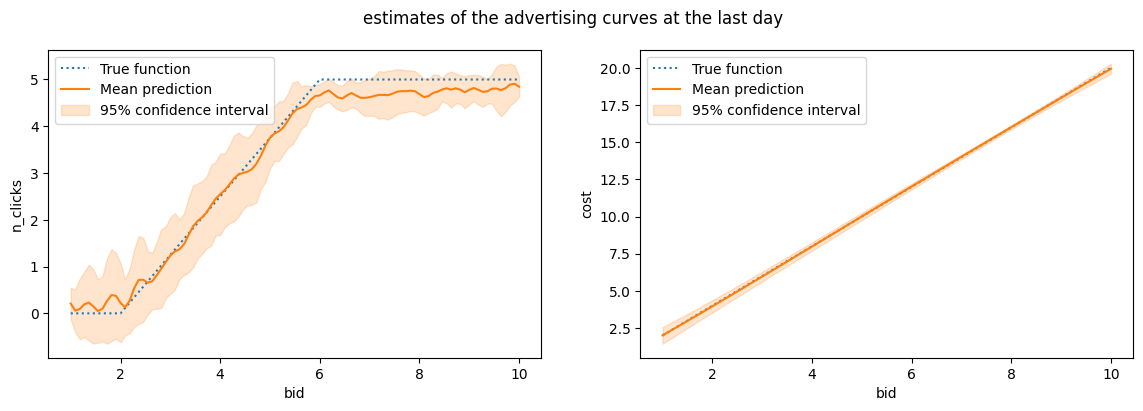

In [118]:
# Plots of the estimates of the functions clicks and costs at the last day
plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day')

plt.subplot(1,2,1)
plt.plot(bids,C1.click_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpucb_n_daily_clicks_hat - 1.96 *gpucb_n_daily_clicks_std, gpucb_n_daily_clicks_hat + 1.96*gpucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cost_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpucb_cum_daily_costs_hat - 1.96 *gpucb_cum_daily_costs_std, gpucb_cum_daily_costs_hat + 1.96*gpucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

In [119]:
# #Plots
# plt.figure(figsize = (14,4))

# plt.subplot(1,2,1)
# plt.xlabel("t")
# plt.ylabel("rewards")
# plt.plot(np.arange(T), np.full(T,opt))
# plt.plot(np.mean(ucb_rewards_per_experiment, axis = 0), color = "C2")
# plt.legend(["optimal","UCB"])

# plt.subplot(1,2,2)
# plt.xlabel("t")
# plt.ylabel("cumulative regret")
# plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), color = "C2")
# plt.legend(["UCB"])

Text(0, 0.5, 'times pulled')

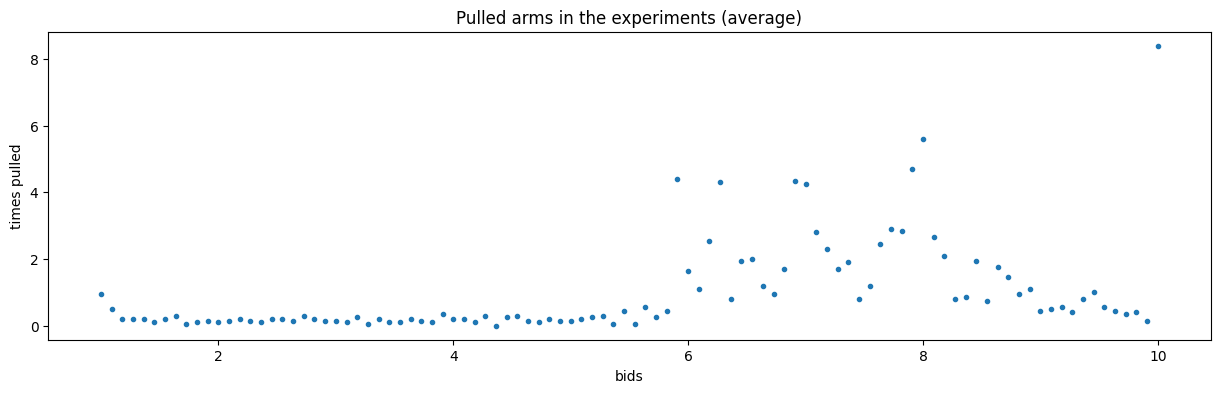

In [194]:
plt.figure(figsize=(15,4))
plt.title("Pulled arms in the experiments (average)")
plt.plot(bids, gpucb_pulled_arms_counter, '.', color = "C0")
plt.xlabel("bids")
plt.ylabel("times pulled")

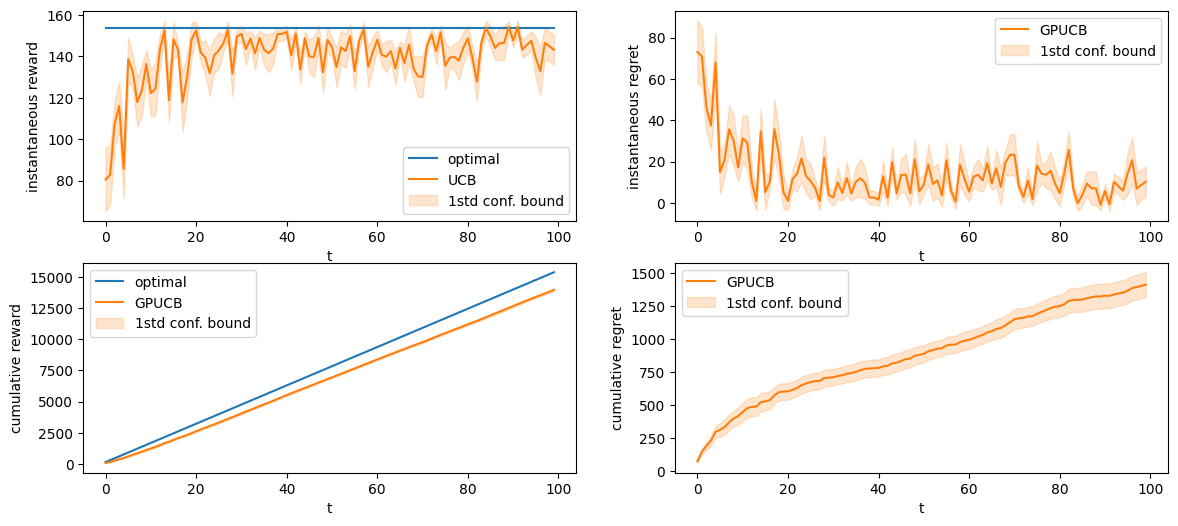

In [121]:
std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

### Thompson sampling

In [122]:
## TS learner

gpts_rewards_per_experiment = []

gpts_n_daily_clicks_hat = np.zeros(len(bids))
gpts_n_daily_clicks_std = np.zeros(len(bids))

gpts_cum_daily_costs_hat = np.zeros(len(bids))
gpts_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
gpts_pulled_arms_counter = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = BiddingEnvironment(bids, C1, sigma_clicks, sigma_costs)
    gpts_learner = Custom_GPTS_Learner(bids)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = gpts_learner.pull_arm(conversion_rate, margin)
        n_daily_clicks, cum_daily_costs, reward = env.round(margin, conversion_rate, pulled_arm)
        gpts_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

        rewards_single_experiment.append(reward)
    gpts_rewards_per_experiment.append(rewards_single_experiment)

    mean_prediction, std_prediction = gpts_learner.clicks_gpts_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpts_n_daily_clicks_hat += mean_prediction / n_experiments
    gpts_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = gpts_learner.costs_gpts_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpts_cum_daily_costs_hat += mean_prediction / n_experiments
    gpts_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    gpts_pulled_arms_counter += np.array([gpts_learner.clicks_gpts_learner.pulled_arms_x.count(bid) for bid in bids]) / n_experiments

0.0%
5.0%
10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%
25.0%
30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%
40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45.0%
50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85.0%
90.0%
95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


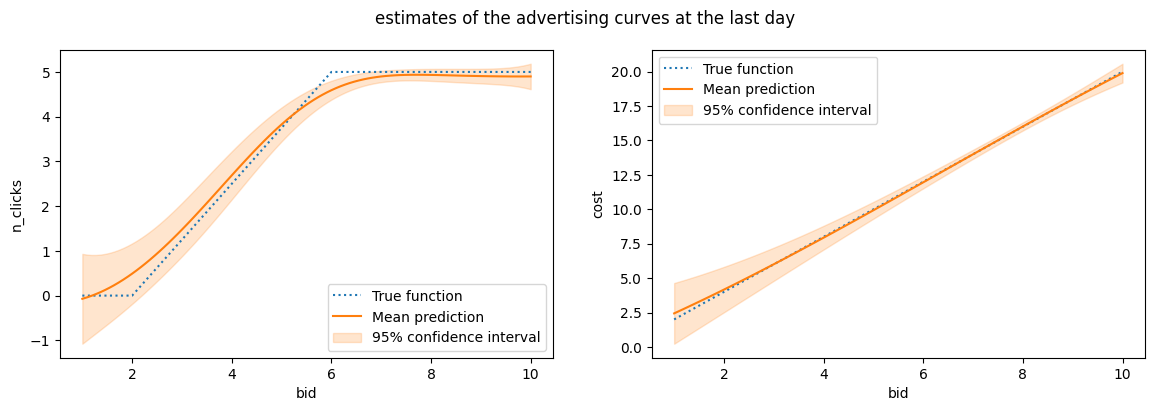

In [123]:
# Plots of the estimates of the functions clicks and costs at the last day
plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day')

plt.subplot(1,2,1)
plt.plot(bids,C1.click_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpts_n_daily_clicks_hat - 1.96 *gpts_n_daily_clicks_std, gpts_n_daily_clicks_hat + 1.96*gpts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cost_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpts_cum_daily_costs_hat - 1.96 *gpts_cum_daily_costs_std, gpts_cum_daily_costs_hat + 1.96*gpts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()


Text(0, 0.5, 'times pulled')

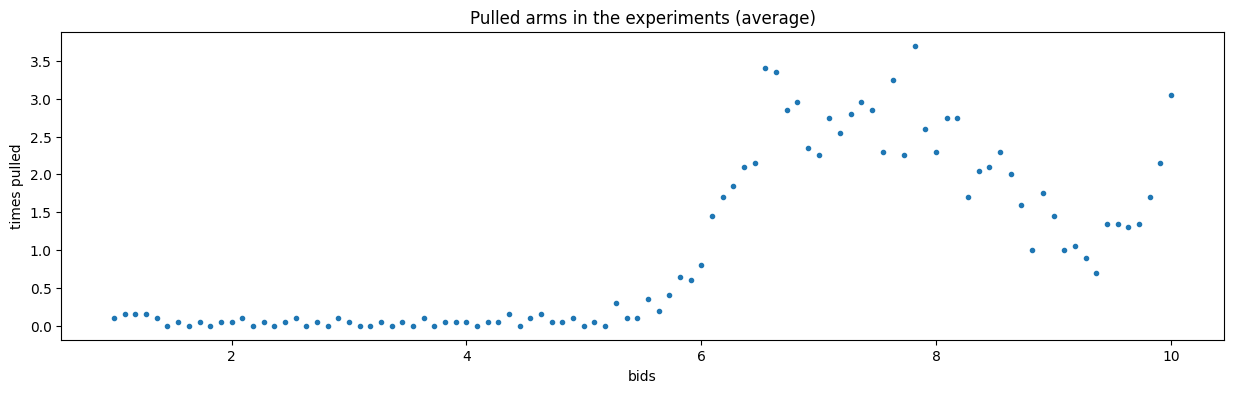

In [193]:
plt.figure(figsize=(15,4))
plt.title("Pulled arms in the experiments (average)")
plt.plot(bids, gpts_pulled_arms_counter, '.', color = "C0")
plt.xlabel("bids")
plt.ylabel("times pulled")

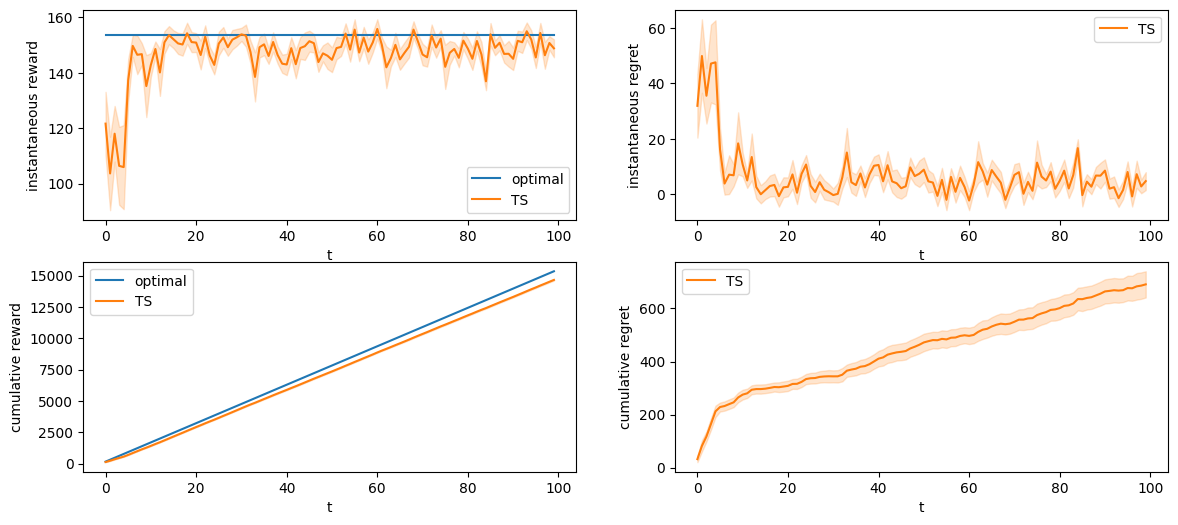

In [125]:
std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["TS"])



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["TS"])

### Plots both methods

In [195]:
ucb_std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

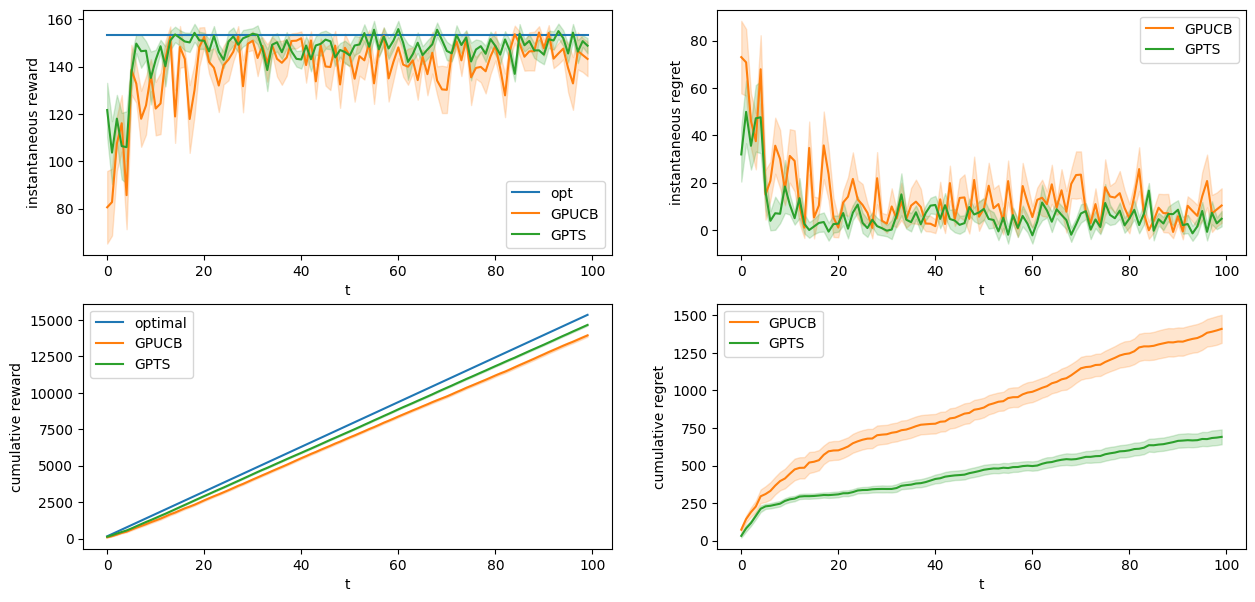

In [197]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "GPTS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

# Step 3

# Step 3

**Framework**:  
just one class,  
alpha, n and c are unknown

### Environment

PricingEnvironment and BiddingEnvironment are more or less those of step1 and step2


**Changes**:
- margin is now an attribute of PricingEnvironment class
- in BiddingEnvironmnent, in the initializer I changed the order of the input user_class
- BiddingEnvironment round() does not return reward and because of that margin and conversion_rate are not inputs anymore

OBS: Things I can do:
- NOT NECESSARYPricingEnvironment and BiddingEnvironment does not really need the user_class as self attribute (it is just used in the __init__() and not in other methods). NOT NECESSARY ----> UPDATE: DONE

In [ ]:
class BiddingEnvironment:#or maybe call it AdvertisingEnvironment
    def __init__(self, bids, sigma_clicks, sigma_costs, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        # self.n_arms = len(bids)
        self.bids = bids
        # self.user_class = user_class

        self.mean_clicks = [user_class.click_function(b) for b in bids]
        self.mean_costs = [user_class.cost_function(b) for b in bids]

        self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
        self.sigmas_costs = np.ones(len(bids)) * sigma_costs


    def round(self, pulled_arm):
        n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
        cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

        return n_daily_clicks, cum_daily_costs

In [ ]:
class PricingEnvironment:
    def __init__(self, prices, margin, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        self.n_arms = len(prices)
        self.prices = prices
        self.margin = margin
        # self.user_class = user_class


        self.convertion_probabilities = [user_class.conversion_rate_function(p) for p in prices]


    def round(self, n_daily_clicks, cum_daily_costs, pulled_arm):
        #OBS:
        # The conversion probability is the probability of buying the item given a price, thus is a Bernoulli probabilty

        alpha = self.convertion_probabilities[pulled_arm]
        n_clicks = max(round(n_daily_clicks), 0)#because negative number of clicks has no sense, also it gives error in np.random.binomial
        reward = np.random.binomial(n_clicks, alpha) * self.margin - cum_daily_costs
        # if reward in expextation: reward = n_daily_clicks * alpha * margin - cum_daily_costs

        return reward

In [ ]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin, user_class):
        self.userclass = user_class #obs:python should take by reference user_class, so it's always the same UserClass object

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, user_class)
        self.pricing_environment = PricingEnvironment(prices, margin, user_class)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        reward = self.pricing_environment.round(n_daily_clicks, cum_daily_costs, pulled_arm_price)

        return n_daily_clicks, cum_daily_costs, reward

## Learners

the reward function in expectation is  
reward(bid,price) = n_daily_clicks(bid) * alpha(price) * margin - cum_daily_costs(bid)

OBS:  
classic bandits for pricing  
GP bandits for advertising

### UCB based

In [ ]:
class UCB1_Learner(Learner):

    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)


    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        #update mean
        # self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.t

        #update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples)

In [ ]:
class GPUCB_Learner(Learner):
    def __init__(self, arms, kernel=None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)

        self.arms = arms

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))#Obs: the hyperparamters will be optimized (changed) during learning

        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 4,
                                           normalize_y=True)



    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append(self.arms[arm_idx])


    def pull_arm(self):
        upper_confidence = self.means + self.sigmas
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        x = np.array(self.pulled_arms_x).reshape((-1,1))
        y = np.array(self.collected_rewards)

        if len(y) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(x,y)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-5)

In [ ]:
class Custom_S3_UCB_Learner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin):# kernel_clicks = None, kernel_costs =None:
        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        super().__init__(self.n_arms_bids * self.n_arms_prices)

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.conversion_rate_learner = UCB1_Learner(self.n_arms_prices)


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice [but still an open question]
        """
        idx_price_arm = self.conversion_rate_learner.pull_arm()

        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        alpha = self.conversion_rate_learner.empirical_means[idx_price_arm] + self.conversion_rate_learner.confidence[idx_price_arm]#upper confidence of the conversion rate

        upper_confidence = ub_clicks * alpha * self.margin - lb_costs
        idx_bid_arm = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])

        return (idx_bid_arm, idx_price_arm)


    def flatten_index(self, idx_bid_arm,idx_price_arm):
        #e.g.: if len(bids) = 10, len(prices) = 3
        #   (0,2) --> 2
        #   (1,0) --> 1*3 = 3
        #   (5,2) --> 5*3 + 2 = 17
        idx = self.n_arms_prices * idx_bid_arm + idx_price_arm
        return idx


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        self.t += 1
        self.update_observations(self.flatten_index(pulled_arm_bid, pulled_arm_price), reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        alpha = (reward + n_daily_clicks) / (n_daily_clicks * self.margin)
        self.conversion_rate_learner.update(pulled_arm_price, alpha)


### TS based

In [ ]:
# TODO

## Example

In [ ]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max

    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

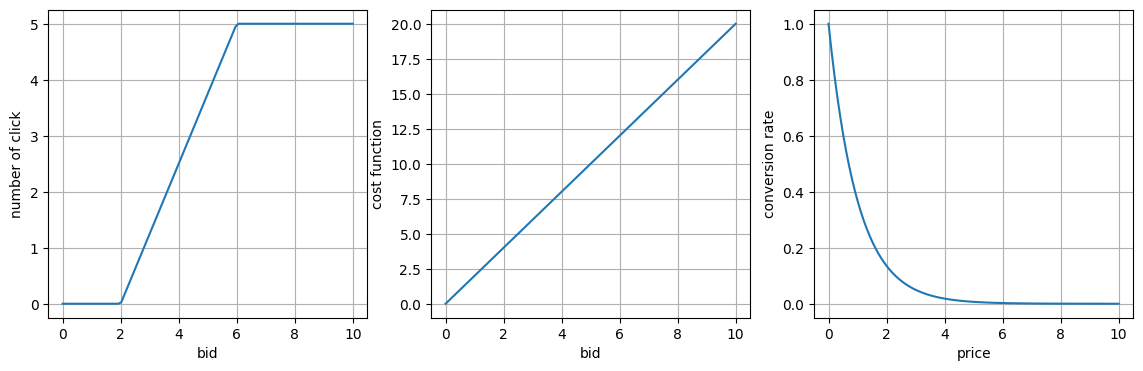

In [ ]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

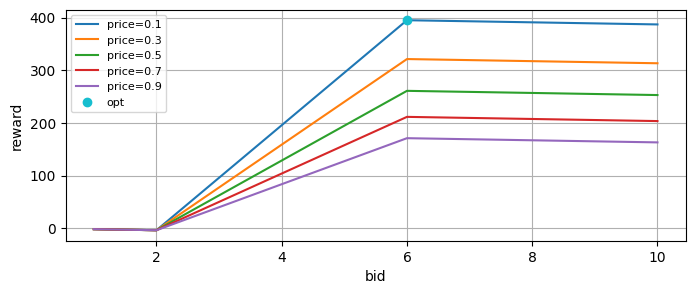

In [ ]:
#Fixed parameters
T = 100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the releated conversion rate

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)
prices =  np.array([1,3,5,7,9]) / 10 #np.array([1,3,5,7,9])


opt_arm_price = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt_price = prices[opt_arm_price]

opt_conversion_rate = C1.conversion_rate_function(opt_price)

# rewards_on_bid_arms = C1.click_function(bids) * opt_conversion_rate * margin - C1.cost_function(bids)
opt_bid_arm = np.argmax(C1.click_function(bids) * opt_conversion_rate * margin - C1.cost_function(bids)) #optimal value of convertion rate between the arms
opt_bid = bids[opt_bid_arm]

opt_n_daily_clicks = C1.click_function(opt_bid)
opt_cum_daily_costs = C1.cost_function(opt_bid)


opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs


n_experiments = 20




plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C1.click_function(bids) * C1.conversion_rate_function(price) * margin - C1.cost_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)

### UCB

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_n_daily_clicks_hat = np.zeros(len(bids))
ucb_n_daily_clicks_std = np.zeros(len(bids))

ucb_cum_daily_costs_hat = np.zeros(len(bids))
ucb_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
ucb_pulled_arms_counter = np.zeros(len(bids)*len(prices))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, C1)
    ucb_learner = Custom_S3_UCB_Learner(bids, prices, margin)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward)

        rewards_single_experiment.append(reward)
    ucb_rewards_per_experiment.append(rewards_single_experiment)


    mean_prediction, std_prediction = ucb_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    ucb_n_daily_clicks_hat += mean_prediction / n_experiments
    ucb_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = ucb_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    ucb_cum_daily_costs_hat += mean_prediction / n_experiments
    ucb_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    ucb_pulled_arms_counter += np.array([len(rewards_i) for rewards_i in ucb_learner.rewards_per_arm]) / n_experiments

0.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

20.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

35.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%
45.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


55.00000000000001%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65.0%
70.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

75.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

90.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


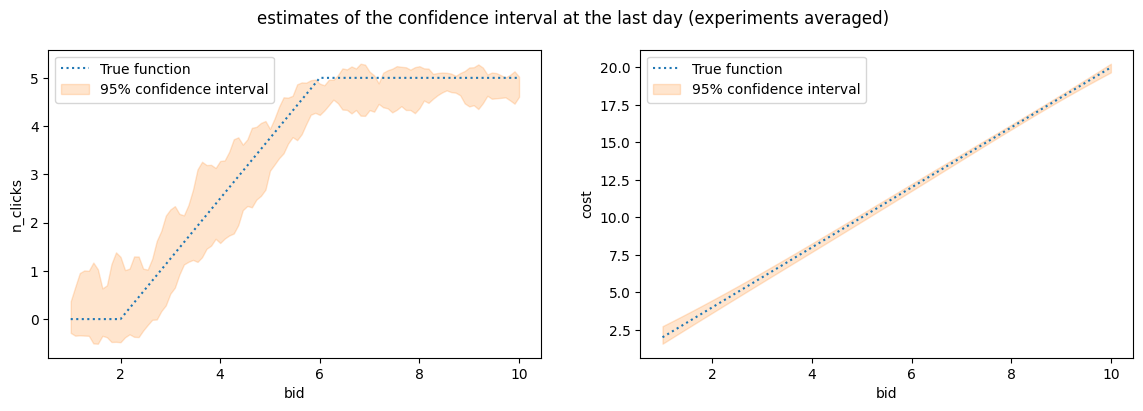

In [ ]:
# Plots of the estimates of the functions clicks and costs at the last day
# plotting ucb_n_daily_clicks_hat as what we get has not sense, since it is a mean over different experiments, so this mean shape is a lot higher better of what we would get in just one run
# but the confidence interval we get is ok

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(bids,C1.click_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_n_daily_clicks_hat - 1.96 * ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + 1.96 * ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cost_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_cum_daily_costs_hat - 1.96 * ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat + 1.96 * ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

In [ ]:
# We can add a plot about the conversion rate #
# TODO
# TODO

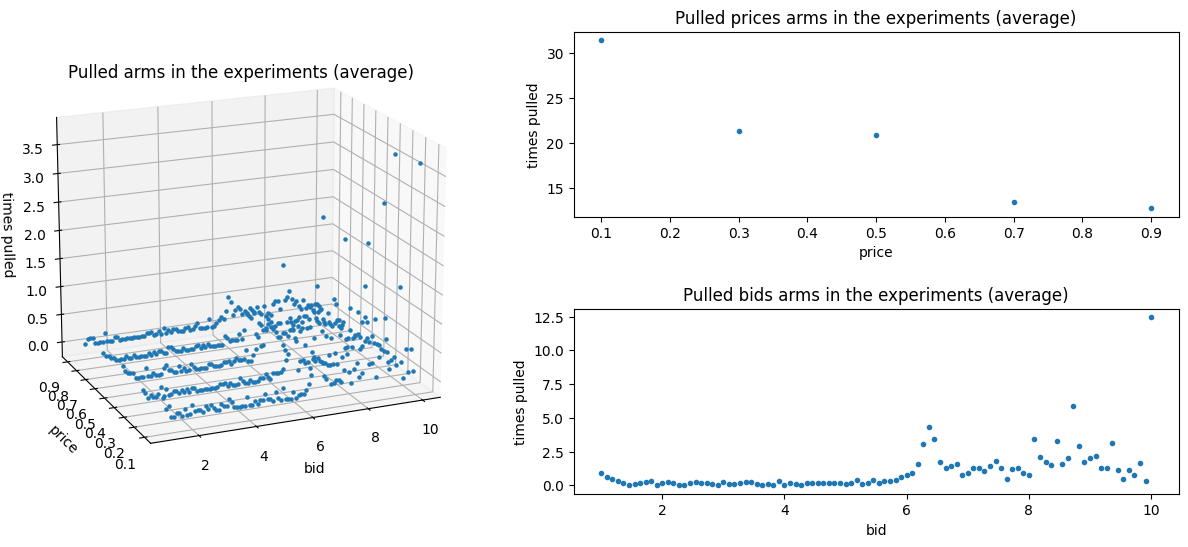

In [ ]:
fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
zz = np.reshape(ucb_pulled_arms_counter, (len(bids),len(prices)))
for i,bid in enumerate(bids):
    for j,price in enumerate(prices):
        ax.scatter(bid,price,zz[i,j], marker = '.', color = 'C0')

ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
# fig.set_size_inches(20, 4)
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)


fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=0, bottom=-.1, right=1.1, top=1.1,

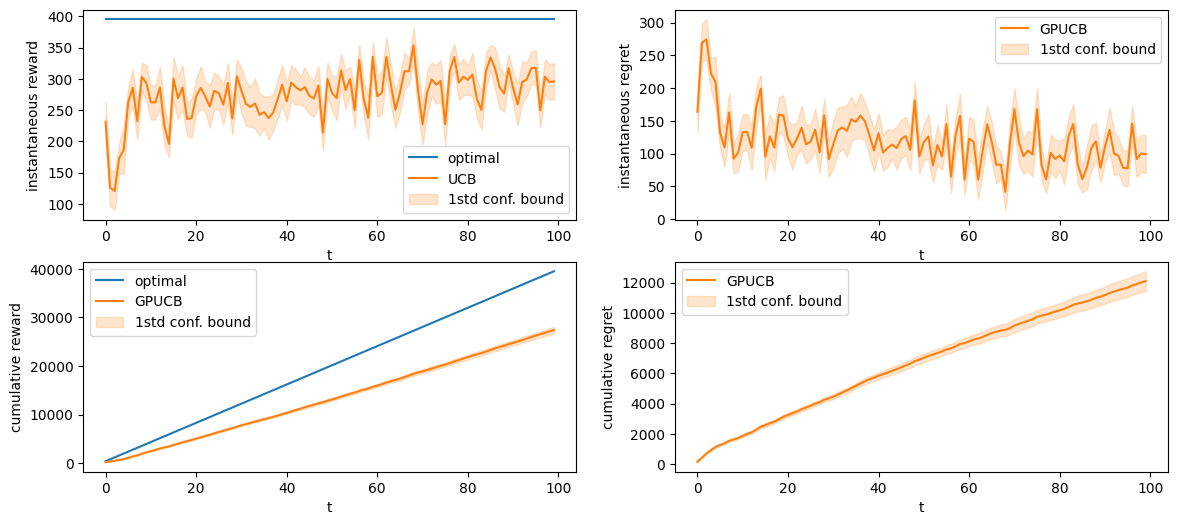

In [ ]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

### TS

In [ ]:
# TODO

### Plots both methods

In [ ]:
# TODO
# TODO after TS

# Step 4

# Step 5

# Step 6